# Rossmann Project - Phase 1 & 2

این نوت‌بوک خروجی کار فاز ۱ و ۲ است: اول تحلیل اکتشافی داده انجام شده و بعد فیچرهای لازم برای مدل‌سازی فازهای بعدی ساخته شده‌اند.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Core data stack
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaling for numeric features in phase 2
from sklearn.preprocessing import RobustScaler

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## 0) Load Data

In [2]:
# File paths
train_path = '../data/competition/train.csv'
store_path = '../data/competition/store.csv'

# Read raw competition files
train_df = pd.read_csv(train_path, low_memory=False)
store_df = pd.read_csv(store_path, low_memory=False)

# Keep Date as datetime from the start (needed for all time features)
train_df['Date'] = pd.to_datetime(train_df['Date'])

print('Train shape:', train_df.shape)
print('Store shape:', store_df.shape)
train_df.head()

Train shape: (1001599, 10)
Store shape: (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
0,1,5,2015-07-17,4852,519,1,1,0,0,303445
1,2,5,2015-07-17,4518,495,1,1,0,1,959585
2,3,5,2015-07-17,6679,673,1,1,0,1,739744
3,4,5,2015-07-17,10514,1343,1,1,0,1,864001
4,5,5,2015-07-17,4355,513,1,1,0,1,981931


In [3]:
print('Missing values in train (>0):')
display(train_df.isna().sum()[train_df.isna().sum() > 0].sort_values(ascending=False).to_frame('missing_count'))

print('Missing values in store (>0):')
display(store_df.isna().sum()[store_df.isna().sum() > 0].sort_values(ascending=False).to_frame('missing_count'))

Missing values in train (>0):


,missing_count


Missing values in store (>0):


,missing_count
Promo2SinceYear,544
Promo2SinceWeek,544
PromoInterval,544
CompetitionOpenSinceMonth,354
CompetitionOpenSinceYear,354
CompetitionDistance,3


## Phase 1 - Data Visualization

### 1) Sales trends over time for selected stores (diverse quantiles)

In [4]:
# Select stores from different sales quantiles so trends are not biased to only high-volume stores
store_sales = train_df.groupby('Store')['Sales'].agg(['mean', 'count']).sort_values('mean', ascending=False)

selected_stores = [
    store_sales.index[0],
    store_sales.index[len(store_sales)//4],
    store_sales.index[len(store_sales)//2],
    store_sales.index[(3*len(store_sales))//4],
    store_sales.index[-1],
]

# Keep one subset for all comparison plots
selected_data = train_df[train_df['Store'].isin(selected_stores)].copy().sort_values('Date')

print('Selected stores:', selected_stores)
selected_data[['Store', 'Date', 'Sales']].head()

Selected stores: [np.int64(262), np.int64(655), np.int64(692), np.int64(317), np.int64(307)]


,Store,Date,Sales
1001176,692,2013-01-01,0
1000746,262,2013-01-01,17267
1001139,655,2013-01-01,0
1000801,317,2013-01-01,0
1000791,307,2013-01-01,0


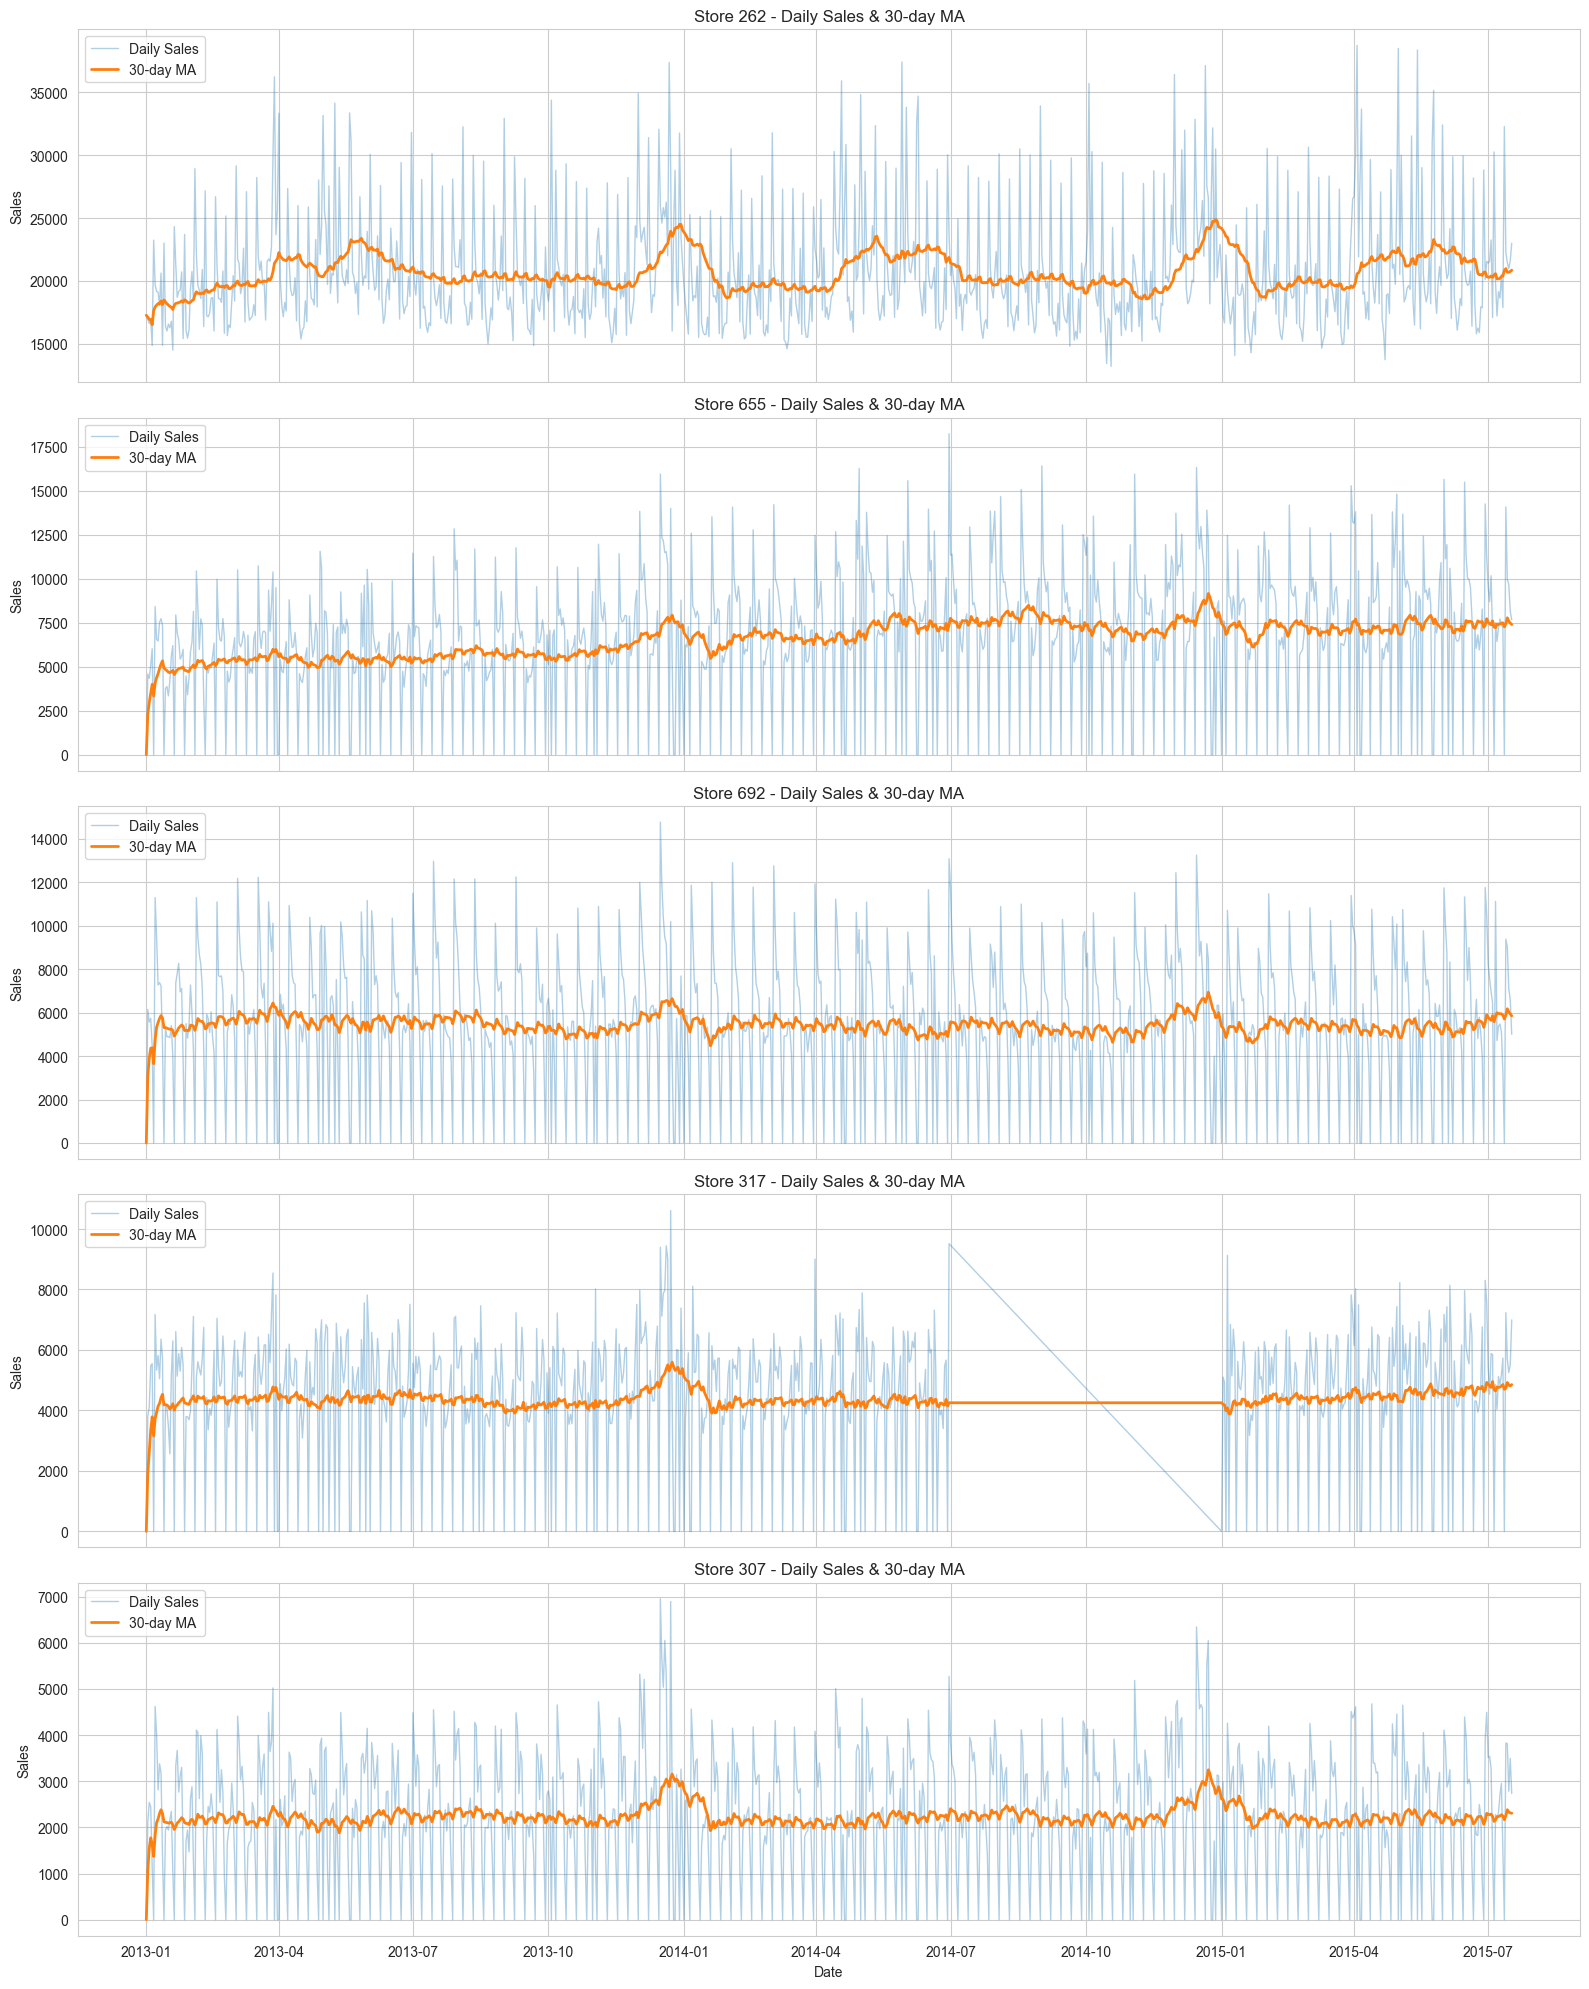

In [5]:
fig, axes = plt.subplots(len(selected_stores), 1, figsize=(16, 4 * len(selected_stores)), sharex=True)

for i, store_id in enumerate(selected_stores):
    # Per-store timeline
    tmp = selected_data[selected_data['Store'] == store_id].sort_values('Date').copy()
    # 30-day moving average to separate trend from daily noise
    tmp['Sales_MA30'] = tmp['Sales'].rolling(30, min_periods=1).mean()

    ax = axes[i] if len(selected_stores) > 1 else axes
    ax.plot(tmp['Date'], tmp['Sales'], alpha=0.35, linewidth=1.0, label='Daily Sales')
    ax.plot(tmp['Date'], tmp['Sales_MA30'], linewidth=2.0, label='30-day MA')
    ax.set_title(f'Store {store_id} - Daily Sales & 30-day MA')
    ax.set_ylabel('Sales')
    ax.legend(loc='upper left')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

### 2) Impact of key features (`Promo`, `StateHoliday`, `SchoolHoliday`)

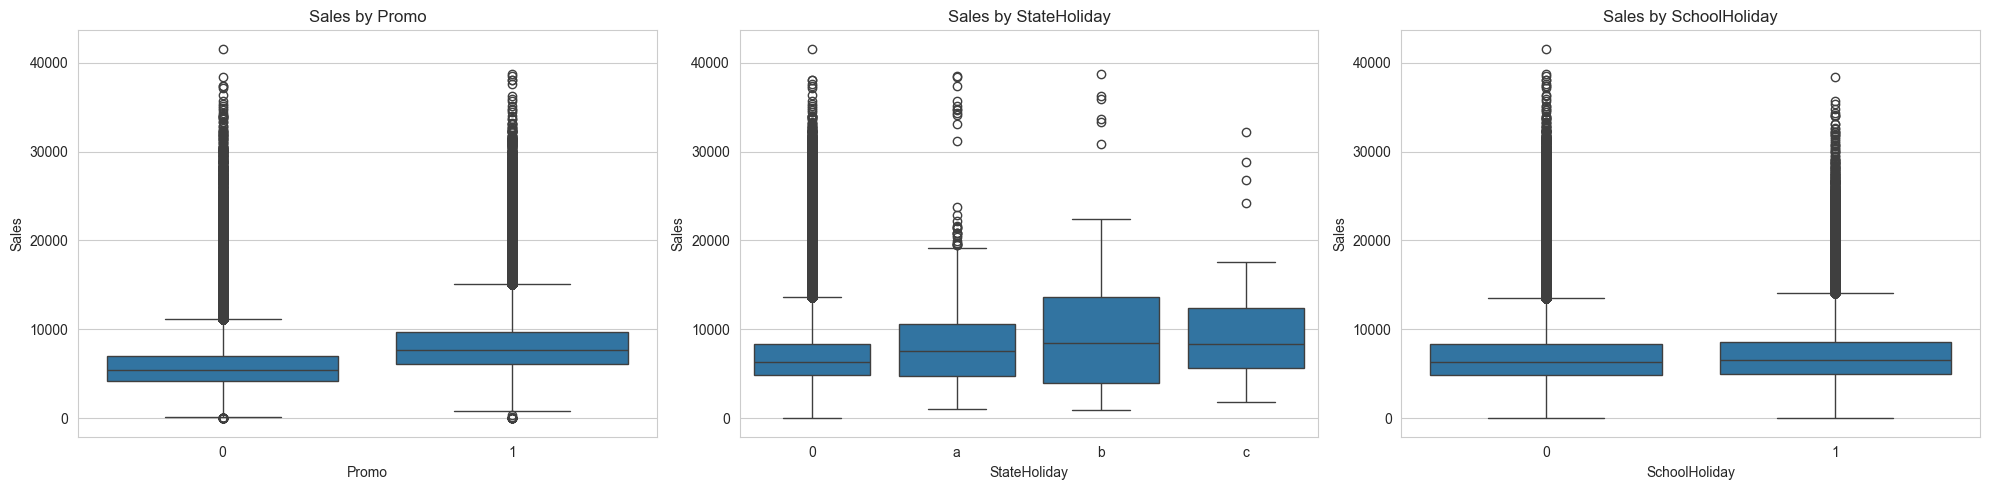

Promo mean/median sales:


,mean,median,count
Promo,,,
0,5930.334374,5458.0,459641
1,8224.401849,7644.0,371331


StateHoliday mean/median sales:


,mean,median,count
StateHoliday,,,
0,6953.437611,6367.0,830062
a,8487.471182,7556.0,694
b,9887.889655,8423.0,145
c,9743.746479,8397.0,71


SchoolHoliday mean/median sales:


,mean,median,count
SchoolHoliday,,,
0,6901.445672,6330.0,675458
1,7190.114678,6547.0,155514


In [6]:
viz_df = train_df[train_df['Open'] == 1].copy()
viz_df['StateHoliday'] = viz_df['StateHoliday'].astype(str)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(data=viz_df, x='Promo', y='Sales', ax=axes[0])
axes[0].set_title('Sales by Promo')

sns.boxplot(data=viz_df, x='StateHoliday', y='Sales', ax=axes[1])
axes[1].set_title('Sales by StateHoliday')

sns.boxplot(data=viz_df, x='SchoolHoliday', y='Sales', ax=axes[2])
axes[2].set_title('Sales by SchoolHoliday')

plt.tight_layout()
plt.show()

print('Promo mean/median sales:')
display(viz_df.groupby('Promo')['Sales'].agg(['mean', 'median', 'count']))

print('StateHoliday mean/median sales:')
display(viz_df.groupby('StateHoliday')['Sales'].agg(['mean', 'median', 'count']))

print('SchoolHoliday mean/median sales:')
display(viz_df.groupby('SchoolHoliday')['Sales'].agg(['mean', 'median', 'count']))

### 3) Correlation analysis (all numeric, Pearson + Spearman)

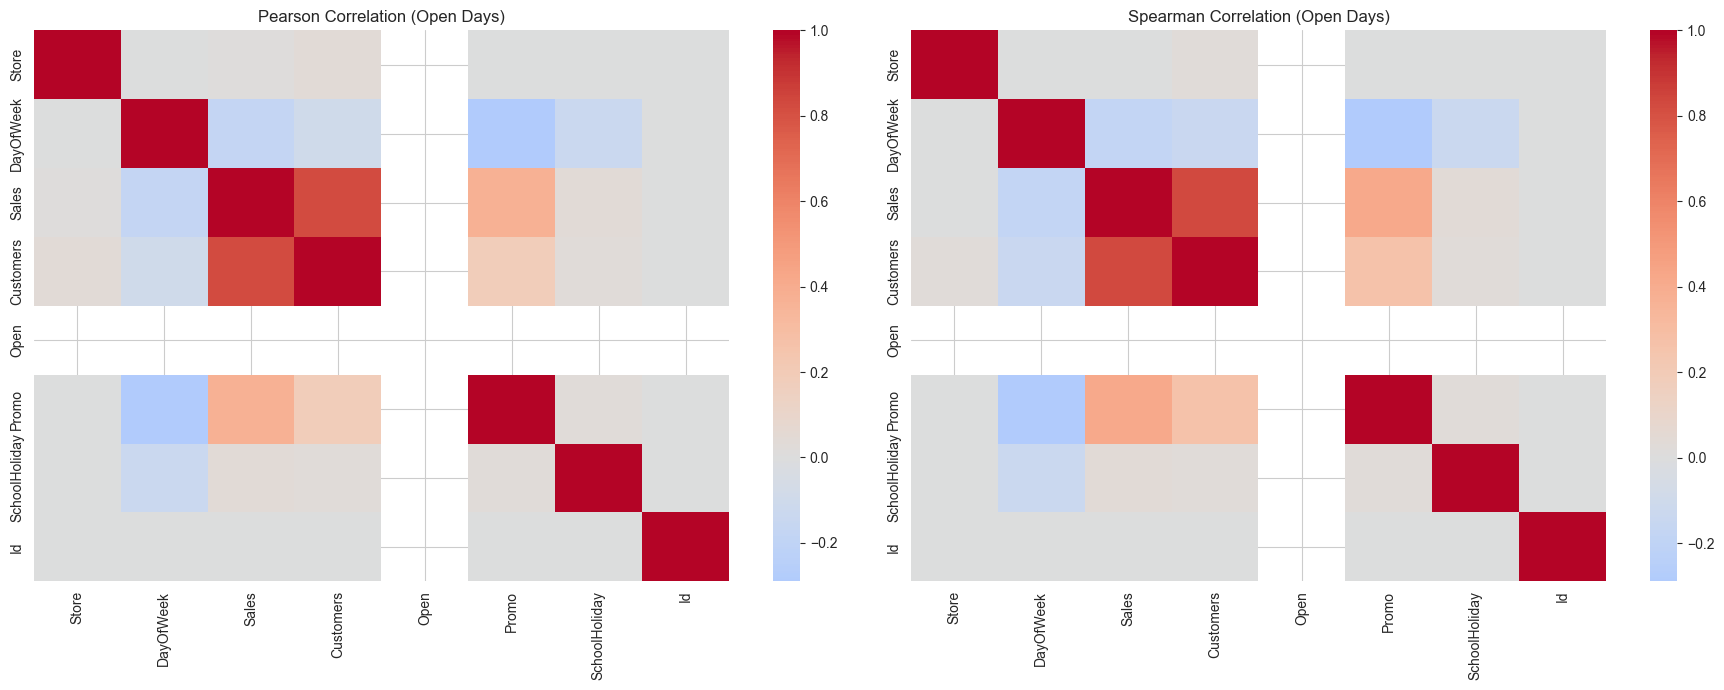

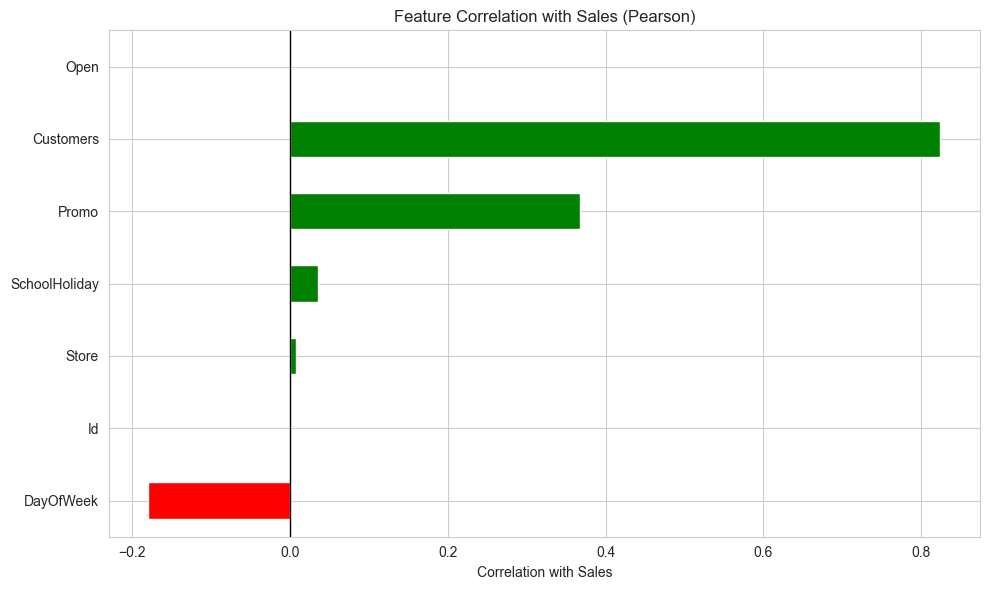

In [7]:
corr_df = train_df[train_df['Open'] == 1].select_dtypes(include=[np.number]).copy()

pearson_corr = corr_df.corr(method='pearson')
spearman_corr = corr_df.corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.heatmap(pearson_corr, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Pearson Correlation (Open Days)')

sns.heatmap(spearman_corr, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Spearman Correlation (Open Days)')

plt.tight_layout()
plt.show()

sales_corr = pearson_corr['Sales'].drop('Sales').sort_values()
colors = ['green' if v > 0 else 'red' for v in sales_corr.values]

plt.figure(figsize=(10, 6))
sales_corr.plot(kind='barh', color=colors)
plt.title('Feature Correlation with Sales (Pearson)')
plt.xlabel('Correlation with Sales')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

### 4) Compare trends across selected stores (daily + 30-day MA)

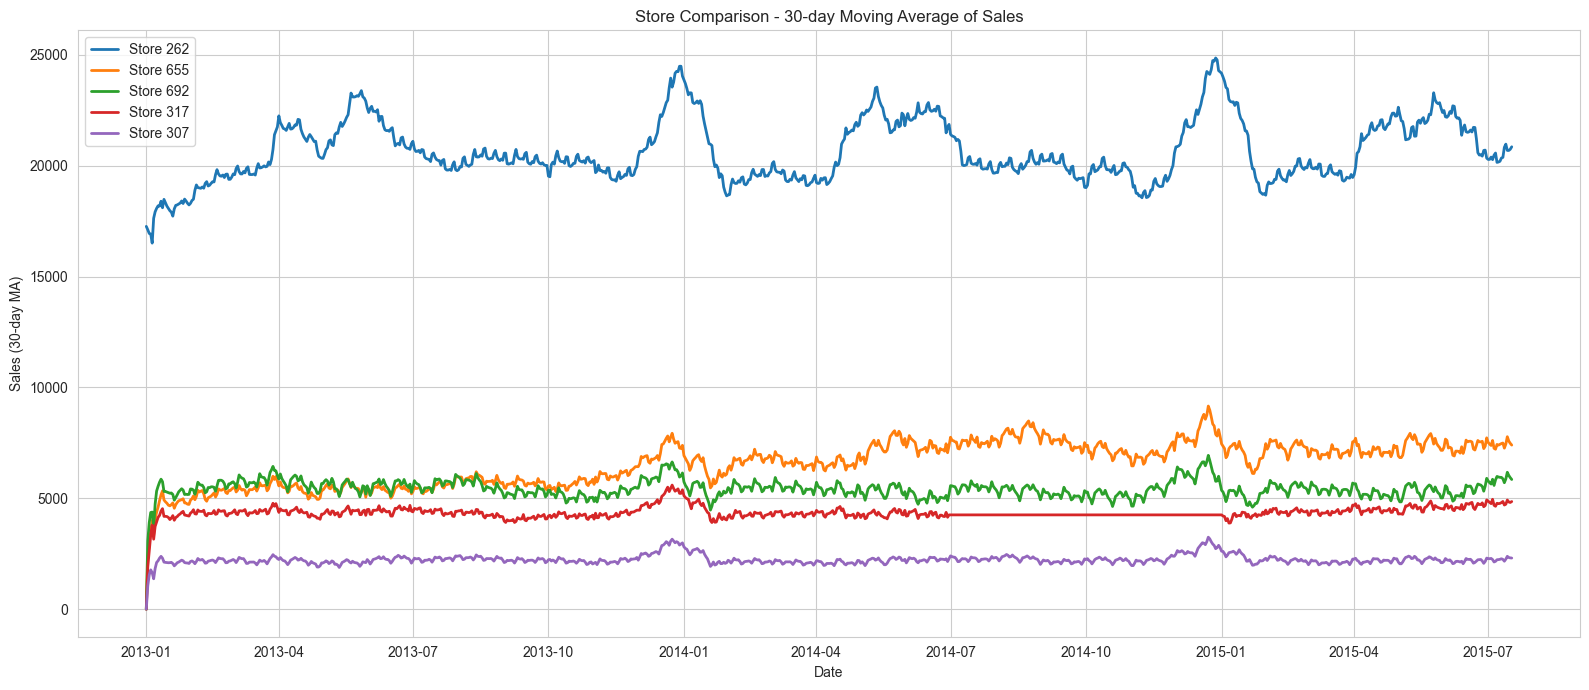

In [8]:
plt.figure(figsize=(16, 7))

for store_id in selected_stores:
    tmp = selected_data[selected_data['Store'] == store_id].sort_values('Date').copy()
    tmp['Sales_MA30'] = tmp['Sales'].rolling(30, min_periods=1).mean()
    plt.plot(tmp['Date'], tmp['Sales_MA30'], linewidth=2, label=f'Store {store_id}')

plt.title('Store Comparison - 30-day Moving Average of Sales')
plt.xlabel('Date')
plt.ylabel('Sales (30-day MA)')
plt.legend()
plt.tight_layout()
plt.show()

## Phase 2 - Feature Engineering

### 1) Merge `sales` + `store` by `Store` (keep all rows; keep `Open` feature)

In [9]:
# Merge sales with store metadata (left join keeps all train rows)
df = train_df.merge(store_df, on='Store', how='left').sort_values(['Store', 'Date']).reset_index(drop=True)
print('Merged shape:', df.shape)
df.head()

Merged shape: (1001599, 19)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,2013-01-01,0,0,0,0,a,1,690197,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,3,2013-01-02,5530,668,1,0,0,1,988300,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,4,2013-01-03,4327,578,1,0,0,1,919910,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,5,2013-01-04,4486,619,1,0,0,1,662609,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,6,2013-01-05,4997,635,1,0,0,1,1008092,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


### 2) Missing-value handling (practical default)

In [10]:
df['StateHoliday'] = df['StateHoliday'].astype(str)

# Promo2-related missing values are structural when Promo2 == 0
df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(0).astype(int)
df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(0).astype(int)
df['PromoInterval'] = df['PromoInterval'].fillna('None')

# Competition open date missing flags + fill
df['CompetitionOpenSinceMonth_missing'] = df['CompetitionOpenSinceMonth'].isna().astype(int)
df['CompetitionOpenSinceYear_missing'] = df['CompetitionOpenSinceYear'].isna().astype(int)
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(0).astype(int)
df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(0).astype(int)

# CompetitionDistance imputation: store-type median, fallback global median + missing flag
df['CompetitionDistance_missing'] = df['CompetitionDistance'].isna().astype(int)
dist_median_by_type = df.groupby('StoreType')['CompetitionDistance'].transform('median')
global_dist_median = df['CompetitionDistance'].median()
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(dist_median_by_type).fillna(global_dist_median)

print('Remaining missing values (>0):')
display(df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).to_frame('missing_count'))

Remaining missing values (>0):


,missing_count


### 3) Time features (core set)

In [11]:
# Core calendar features (simple and strong baseline for tree models)
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(int)
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

df[['Date', 'year', 'month', 'weekofyear', 'day', 'dayofweek', 'is_weekend']].head()

,Date,year,month,weekofyear,day,dayofweek,is_weekend
0,2013-01-01,2013,1,1,1,1,0
1,2013-01-02,2013,1,1,2,2,0
2,2013-01-03,2013,1,1,3,3,0
3,2013-01-04,2013,1,1,4,4,0
4,2013-01-05,2013,1,1,5,5,1


### 4) Lag and rolling features (strong setup)

In [12]:
lag_list = [1, 7, 14, 28]
roll_windows = [7, 14, 28, 56]

lag_feature_cols = []
roll_mean_cols = []
roll_std_cols = []

for lag in lag_list:
    sales_lag_col = f'Sales_lag_{lag}'
    customers_lag_col = f'Customers_lag_{lag}'

    df[sales_lag_col] = df.groupby('Store')['Sales'].shift(lag)
    df[customers_lag_col] = df.groupby('Store')['Customers'].shift(lag)

    lag_feature_cols.extend([sales_lag_col, customers_lag_col])

shifted_sales = df.groupby('Store')['Sales'].shift(1)
shifted_customers = df.groupby('Store')['Customers'].shift(1)

for w in roll_windows:
    sales_roll_mean_col = f'Sales_roll_mean_{w}'
    sales_roll_std_col = f'Sales_roll_std_{w}'
    customers_roll_mean_col = f'Customers_roll_mean_{w}'
    customers_roll_std_col = f'Customers_roll_std_{w}'

    df[sales_roll_mean_col] = shifted_sales.groupby(df['Store']).rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
    df[sales_roll_std_col] = shifted_sales.groupby(df['Store']).rolling(window=w, min_periods=1).std().reset_index(level=0, drop=True)

    df[customers_roll_mean_col] = shifted_customers.groupby(df['Store']).rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
    df[customers_roll_std_col] = shifted_customers.groupby(df['Store']).rolling(window=w, min_periods=1).std().reset_index(level=0, drop=True)

    roll_mean_cols.extend([sales_roll_mean_col, customers_roll_mean_col])
    roll_std_cols.extend([sales_roll_std_col, customers_roll_std_col])

generated_ts_cols = lag_feature_cols + roll_mean_cols + roll_std_cols
missing_before = df[generated_ts_cols].isna().sum().sum()

# Keep missing-pattern information explicitly
for col in generated_ts_cols:
    df[f'{col}_missing'] = df[col].isna().astype('int8')

# Safe imputation for time-series engineered features (no future-value borrowing)
df[lag_feature_cols + roll_mean_cols] = df[lag_feature_cols + roll_mean_cols].fillna(0.0)
df[roll_std_cols] = df[roll_std_cols].fillna(0.0)

missing_after = df[generated_ts_cols].isna().sum().sum()
print(f'Missing in lag/rolling features - before: {missing_before:,} | after: {missing_after:,}')

df.filter(regex='Sales_lag|Customers_lag|Sales_roll|Customers_roll').head(20)

Missing in lag/rolling features - before: 138,260 | after: 0


,Sales_lag_1,Customers_lag_1,Sales_lag_7,Customers_lag_7,Sales_lag_14,Customers_lag_14,Sales_lag_28,Customers_lag_28,Sales_roll_mean_7,Sales_roll_std_7,...,Sales_roll_mean_56_missing,Customers_roll_mean_56_missing,Sales_roll_std_7_missing,Customers_roll_std_7_missing,Sales_roll_std_14_missing,Customers_roll_std_14_missing,Sales_roll_std_28_missing,Customers_roll_std_28_missing,Sales_roll_std_56_missing,Customers_roll_std_56_missing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,1,1,1,1,1,1,1,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,1,1,1,1,1,1,1,1
2,5530.0,668.0,0.0,0.0,0.0,0.0,0.0,0.0,2765.000000,3910.300500,...,0,0,0,0,0,0,0,0,0,0
3,4327.0,578.0,0.0,0.0,0.0,0.0,0.0,0.0,3285.666667,2908.351137,...,0,0,0,0,0,0,0,0,0,0
4,4486.0,619.0,0.0,0.0,0.0,0.0,0.0,0.0,3585.750000,2449.327306,...,0,0,0,0,0,0,0,0,0,0
5,4997.0,635.0,0.0,0.0,0.0,0.0,0.0,0.0,3868.000000,2213.081223,...,0,0,0,0,0,0,0,0,0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3223.333333,2532.144045,...,0,0,0,0,0,0,0,0,0,0
7,7176.0,785.0,0.0,0.0,0.0,0.0,0.0,0.0,3788.000000,2752.283961,...,0,0,0,0,0,0,0,0,0,0
8,5580.0,654.0,5530.0,668.0,0.0,0.0,0.0,0.0,4585.142857,2231.018633,...,0,0,0,0,0,0,0,0,0,0
9,5471.0,626.0,4327.0,578.0,0.0,0.0,0.0,0.0,4576.714286,2226.961885,...,0,0,0,0,0,0,0,0,0,0


### 5) Periodic features (Fourier) + distance to nearest state holiday

In [13]:
# Fourier features: smooth yearly seasonality signal
day_of_year = df['Date'].dt.dayofyear
period = 365.25
n_terms = 3

for k in range(1, n_terms + 1):
    df[f'fourier_sin_{k}'] = np.sin(2 * np.pi * k * day_of_year / period)
    df[f'fourier_cos_{k}'] = np.cos(2 * np.pi * k * day_of_year / period)

# Distance to nearest state holiday date
holiday_dates = np.sort(df.loc[df['StateHoliday'] != '0', 'Date'].dt.normalize().unique())
all_dates = df['Date'].dt.normalize().values.astype('datetime64[D]')

if len(holiday_dates) == 0:
    df['days_to_nearest_state_holiday'] = np.nan
else:
    holiday_days = holiday_dates.astype('datetime64[D]')
    pos = np.searchsorted(holiday_days, all_dates)

    left_idx = np.clip(pos - 1, 0, len(holiday_days) - 1)
    right_idx = np.clip(pos, 0, len(holiday_days) - 1)

    left_diff = np.abs((all_dates - holiday_days[left_idx]).astype('timedelta64[D]').astype(int))
    right_diff = np.abs((holiday_days[right_idx] - all_dates).astype('timedelta64[D]').astype(int))
    df['days_to_nearest_state_holiday'] = np.minimum(left_diff, right_diff)


df[['Date', 'StateHoliday', 'days_to_nearest_state_holiday', 'fourier_sin_1', 'fourier_cos_1']].head(10)

,Date,StateHoliday,days_to_nearest_state_holiday,fourier_sin_1,fourier_cos_1
0,2013-01-01,a,0,0.017202,0.999852
1,2013-01-02,0,1,0.034398,0.999408
2,2013-01-03,0,2,0.051584,0.998669
3,2013-01-04,0,2,0.068755,0.997634
4,2013-01-05,0,1,0.085906,0.996303
5,2013-01-06,0,0,0.103031,0.994678
6,2013-01-07,0,1,0.120126,0.992759
7,2013-01-08,0,2,0.137185,0.990545
8,2013-01-09,0,3,0.154204,0.988039
9,2013-01-10,0,4,0.171177,0.985240


### 6) Categorical encoding + numeric scaling (RobustScaler)

In [14]:
# One-hot encode selected categorical features
categorical_cols = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

# Prepare numeric columns for robust scaling
exclude_cols = ['Date', 'Sales']
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]

scaler = RobustScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print('Final engineered dataframe shape:', df.shape)
print('Number of numeric columns scaled:', len(numeric_cols))

Final engineered dataframe shape: (1001599, 94)
Number of numeric columns scaled: 77


### 7) Time-based split (80/10/10 chronological)

In [15]:
# Chronological split (no shuffling) to mimic forecasting setup
unique_dates = np.array(sorted(df['Date'].unique()))
n_dates = len(unique_dates)

train_end_idx = int(n_dates * 0.80)
val_end_idx = int(n_dates * 0.90)

train_end_date = unique_dates[train_end_idx - 1]
val_end_date = unique_dates[val_end_idx - 1]

train_split = df[df['Date'] <= train_end_date].copy()
val_split = df[(df['Date'] > train_end_date) & (df['Date'] <= val_end_date)].copy()
test_split = df[df['Date'] > val_end_date].copy()

print('Date boundaries:')
print('  Train end:', train_end_date)
print('  Val end  :', val_end_date)

print('Split shapes:')
print('  Train:', train_split.shape)
print('  Val  :', val_split.shape)
print('  Test :', test_split.shape)

Date boundaries:
  Train end: 2015-01-12 00:00:00
  Val end  : 2015-04-15 00:00:00
Split shapes:
  Train: (794209, 94)
  Val  : (103695, 94)
  Test : (103695, 94)


In [16]:
from pathlib import Path
import json
import pickle

# Output layout
output_dir = Path('../data/phase2_output')
pkl_dir = output_dir / 'pkl'
csv_dir = output_dir / 'csv'
output_dir.mkdir(parents=True, exist_ok=True)
pkl_dir.mkdir(parents=True, exist_ok=True)
csv_dir.mkdir(parents=True, exist_ok=True)

# --------------------
# 1) Save data artifacts in PKL (fast load, keeps dtypes)
# --------------------
df.to_pickle(pkl_dir / 'engineered_full.pkl')
train_split.to_pickle(pkl_dir / 'train_split.pkl')
val_split.to_pickle(pkl_dir / 'val_split.pkl')
test_split.to_pickle(pkl_dir / 'test_split.pkl')

# Scaler object (pickle only)
with open(pkl_dir / 'robust_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# --------------------
# 2) Save tabular artifacts in CSV (portable format)
# --------------------
df.to_csv(csv_dir / 'engineered_full.csv', index=False)
train_split.to_csv(csv_dir / 'train_split.csv', index=False)
val_split.to_csv(csv_dir / 'val_split.csv', index=False)
test_split.to_csv(csv_dir / 'test_split.csv', index=False)

# --------------------
# 3) Save metadata and feature list at root
# --------------------
feature_cols = [c for c in df.columns if c not in ['Date', 'Sales']]
metadata = {
    'engineered_shape': [int(df.shape[0]), int(df.shape[1])],
    'train_shape': [int(train_split.shape[0]), int(train_split.shape[1])],
    'val_shape': [int(val_split.shape[0]), int(val_split.shape[1])],
    'test_shape': [int(test_split.shape[0]), int(test_split.shape[1])],
    'target_column': 'Sales',
    'date_column': 'Date',
    'n_features': int(len(feature_cols)),
    'pkl_subdir': 'pkl',
    'csv_subdir': 'csv'
}

with open(output_dir / 'metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

with open(output_dir / 'feature_columns.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(feature_cols))

# --------------------
# 4) README for downstream phases
# --------------------
readme_text = """# Phase 2 Output Files

This folder stores the final engineered outputs from `solution/phase1_phase2.ipynb`.

## Folder structure

- `pkl/`: binary artifacts for fast loading in Python.
- `csv/`: tabular artifacts in CSV format for portability.
- `metadata.json`: shapes, key columns, and export structure.
- `feature_columns.txt`: model feature list (all columns except `Date` and `Sales`).

## Files and usage

### pkl/

- `engineered_full.pkl`: full engineered dataframe (all rows).
- `train_split.pkl`: chronological train split (80%).
- `val_split.pkl`: chronological validation split (10%).
- `test_split.pkl`: chronological test split (10%).
- `robust_scaler.pkl`: fitted `RobustScaler` used on numeric columns.

Recommended for Phase 3/4/5 if you work in Python and want dtype fidelity and faster IO.

### csv/

- `engineered_full.csv`: full engineered dataframe in CSV format.
- `train_split.csv`: train split in CSV.
- `val_split.csv`: validation split in CSV.
- `test_split.csv`: test split in CSV.

Recommended when sharing data across tools/languages or for quick manual inspection.

## Quick load examples

```python
import pandas as pd
import pickle

base = 'data/phase2_output'

# PKL
train_df = pd.read_pickle(f'{base}/pkl/train_split.pkl')
with open(f'{base}/pkl/robust_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# CSV
train_csv = pd.read_csv(f'{base}/csv/train_split.csv')
```

## Notes

- Target column: `Sales`
- Date column: `Date`
- Features for modeling are listed in `feature_columns.txt`.
"""

with open(output_dir / 'README.md', 'w', encoding='utf-8') as f:
    f.write(readme_text)

print('Saved phase2 outputs to:', output_dir.resolve())
print('\nTop-level files:')
for p in sorted(output_dir.glob('*')):
    print('-', p.name)

print('\nPKL files:')
for p in sorted(pkl_dir.glob('*')):
    print('-', p.name)

print('\nCSV files:')
for p in sorted(csv_dir.glob('*')):
    print('-', p.name)

Saved phase2 outputs to: C:\Users\USER\Desktop\Archive\data\phase2_output

Top-level files:
- csv
- feature_columns.txt
- metadata.json
- pkl
- README.md

PKL files:
- engineered_full.pkl
- robust_scaler.pkl
- test_split.pkl
- train_split.pkl
- val_split.pkl

CSV files:
- engineered_full.csv
- test_split.csv
- train_split.csv
- val_split.csv


## خروجی نهایی فاز ۲

- دیتافریم مهندسی‌شده: `df`
- اسپلید زمانی: `train_split`, `val_split`, `test_split`
- اسکیلر عددی: `scaler`